In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from wordfreq import zipf_frequency
from wordfreq import word_frequency
from collections import Counter

In [249]:
file=open("valid-wordle-words.txt")
words=file.read().split()
df = pd.read_excel("Problem_C_Data_Wordle(1).xlsx")
subwords = df["Word"]
avgscores = df["Average Score"]
CZERO = ord("a")

12972

In [251]:
wordfreq = np.asarray(
    [word_frequency(words[i], "en") for i in range(len(words))], dtype=np.float64
)
maxfreq=max(wordfreq)
wordfreq=wordfreq/maxfreq
wordfreq=1/(1+np.exp(-(wordfreq-0.5)*3))

avgscores=np.asarray(avgscores)-min(avgscores)
avgscores=avgscores/max(avgscores)

In [252]:
charpos=np.zeros((26,6))
for i in range(len(words)):
    for j in range(5):
       charpos[ord(words[i][j])-CZERO][j]+=wordfreq[i]
       charpos[ord(words[i][j])-CZERO][5]+=wordfreq[i]

In [253]:
charcombo = np.zeros((26, 26))
for i in range(len(words)):
    for j in range(4):
        a = ord(words[i][j]) - ord("a")
        b = ord(words[i][j + 1]) - ord("a")
        charcombo[a][b] += wordfreq[i]

In [254]:
charnumber = np.zeros(len(words))
count = 0
for i in range(len(words)):
    count = 0
    word = words[i]
    for j in range(5):
        same = False
        for k in range(j):
            if word[k] == word[j]:
                same = True
                break
        if not same:
            count += 1
    charnumber[i] = count

In [255]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [256]:
def getfeaturefq(word):
    # charnumber
    f0 = 0
    for j in range(5):
        same = False
        for k in range(j):
            if word[k] == word[j]:
                same = True
                break
        if not same:
            f0 += 1
    dummy = np.zeros((5))
    dummy[f0 - 1] = 1

    # charfeq
    f1 = 0
    for i in range(5):
        f1 += charpos[ord(word[i]) - ord("a")][5]
    f1 /= np.sum(charpos[:, -1])

    # charpos
    f2 = 0
    for i in range(5):
        f2 += charpos[ord(word[i]) - ord("a")][i]
    f2 /= np.sum(charpos[:, 0]) * 5

    # charcombo
    f3 = 0
    for i in range(4):
        a = ord(word[i]) - ord("a")
        b = ord(word[i + 1]) - ord("a")
        f3 += charcombo[a][b]
    f3 /= np.sum(charcombo)

    f4 = syllable_count(word)

    f5 = zipf_frequency(word, "en")
    f6 = word_frequency(word, "en")

    lo = 0
    hi = len(words) - 1
    while hi > lo:
        mid = (lo + hi) // 2
        if words[mid] < word:
            lo = mid + 1
        else:
            hi = mid
    f7 = wordfreq[lo]

    return np.concatenate((dummy, np.asarray([f1,f2,f3,f4,f5,f6,f7])),axis=0)
    # return np.asarray([f1])

0.36787789621385303


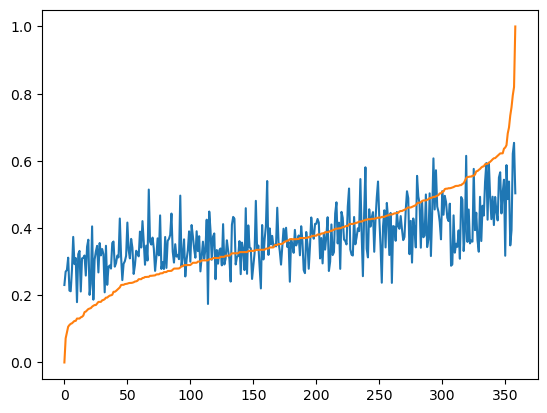

In [257]:
features=[getfeaturefq(word) for word in subwords]

reg=LinearRegression().fit(features,avgscores)
prescore=[reg.predict([features[i]])[0] for i in range(359)]
print(reg.score(features,avgscores))


pairs=np.asarray([prescore,avgscores]).T
pairs=np.asarray(sorted(pairs,key=lambda e:e[1])).T
plt.plot(np.arange(359),pairs[0],pairs[1])